# **les métaheuristiques évolutionnaires (AG & ACO)** 

# Methode 1 : ACO : Colonie de fourmis  
La méthode ACO est une méthode d'optimisation inspirée par le comportement des colonies de fourmis à la recherche de nourriture. Elle est couramment utilisée pour résoudre des problèmes d'optimisation combinatoire, notamment le problème du voyageur de commerce.  

Fonctionnement bref :  

**1- Initialisation des phéromones :** Les phéromones sont déposées initialement sur toutes les routes possibles.  
**2- Parcours des fourmis :** Les fourmis explorent les différentes solutions en choisissant les chemins en fonction des phéromones et des heuristiques.  
**3- Dépôt et évaporation des phéromones :** Les chemins parcourus par les fourmis reçoivent un dépôt de phéromones, favorisant les chemins les plus courts. Les phéromones s'évaporent progressivement pour éviter la convergence prématurée.  
**4- Itérations :** Les étapes 2 et 3 sont répétées pour un nombre fixe d'itérations ou jusqu'à ce qu'un critère d'arrêt soit atteint.  
**5- Récupération de la meilleure solution :** La meilleure solution trouvée est extraite des chemins parcourus par les fourmis

Le code suivant fournit une implémentation de base de l'algorithme ACO pour résoudre le problème du voyageur de commerce.

In [36]:
import os
import numpy as np
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.sparse import csr_matrix
maxsize = float('inf')
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import numpy as np
import random

In [37]:
# Charger le fichier XML
tree = ET.parse('data.xml')
root = tree.getroot()

# Initialiser la matrice des distances
nombre_villes = 17
matrice_distances = np.zeros((nombre_villes, nombre_villes))

# Remplir la matrice des distances
for i, vertex in enumerate(root.find('graph').findall('vertex')):
    for edge in vertex.findall('edge'):
        j = int(edge.text)  # L'indice de la ville de destination
        cost = float(edge.get('cost'))  # Le coût pour se rendre à cette ville
        matrice_distances[i, j] = cost


In [38]:
# D'abord on cree un classe pour la methode d'optimisation des colonies de fourmies 
class AntColonyOptimizer:
    def __init__(self, matrice_distances, n_ants, n_best, n_iterations, decay, alpha=1, beta=1):
        """
        ACO pour le problème du voyageur de commerce.
        :param matrice_distances: Matrice de matrice_distances NxN
        :param n_ants: Nombre de fourmis
        :param n_best: Nombre des meilleures fourmis qui déposent du phéromone
        :param n_iterations: Nombre d'itérations
        :param decay: Taux d'évaporation du phéromone
        :param alpha: Influence du phéromone
        :param beta: Influence de l'heuristique (1/distance)
        """
        self.matrice_distances = matrice_distances
        self.pheromone = np.ones(self.matrice_distances.shape) / len(matrice_distances)
        self.all_inds = range(len(matrice_distances))
        self.n_ants = n_ants
        self.n_best = n_best
        self.n_iterations = n_iterations
        self.decay = decay
        self.alpha = alpha
        self.beta = beta

    def run(self):
        # On intiliase le chemin le plus court ainsi que sa longueur 
        shortest_path = None
        shortest_path_length = float('inf')
        for _ in range(self.n_iterations):
            # Generation de tous les chemins parcourus par les fourmis dans cette iteration
            all_paths = self.gen_all_paths()
            # Dépôt de phéromones sur les meilleurs chemins parcourus.
            self.spread_pheromone(all_paths, self.n_best, shortest_path_length)
            # Évaporation des phéromones sur toutes les routes.
            self.decay_pheromones()
            # Recherche du plus court chemin parcouru par les fourmis dans cette iteration 
            shortest_path, shortest_path_length = self.find_shortest_path(all_paths)
        return shortest_path, shortest_path_length


    # Réduction des phéromones sur toutes les routes par un facteur de décroissance.
    def decay_pheromones(self):
        self.pheromone *= self.decay

    
    # Methode pour le depot du pheromone sur les chemins parcourus 
    def spread_pheromone(self, all_paths, n_best, shortest_path_length):
        # Tri des chemins parcourus en fonction de leur longueur.
        sorted_paths = sorted(all_paths, key=lambda x: x[1])
        # On parcourt les n_best chemins 
        for path, length in sorted_paths[:n_best]:
            for move in path:
                # Pour chaque mouvement on depose un pheromone 
                self.pheromone[move] += 1.0 / self.matrice_distances[move]

    def gen_path_dist(self, path):
        total_dist = 0
        for ele in path:
            total_dist += self.matrice_distances[ele]
        return total_dist

    def find_shortest_path(self, all_paths):
        shortest_path = min(all_paths, key=lambda x: x[1])
        return shortest_path

    #  Generation de tous les chemins pour cette iteration 
    def gen_all_paths(self):
        all_paths = []
        # Pour chaque fourmi est generé un chemin 
        for _ in range(self.n_ants):
            path = self.gen_path(0)  # La fourmi commence son parcours toujours par la ville 0 
            all_paths.append((path, self.gen_path_dist(path)))
        return all_paths

    # Generation d'un chemin pour une fourmi 
    def gen_path(self, start):
        path = []
        visited = set()
        visited.add(start)
        prev = start # Avant de passer au prochain on enregistre le debut dans prev 
        for _ in range(len(self.matrice_distances) - 1):
            move = self.pick_move(self.pheromone[prev], self.matrice_distances[prev], visited)
            path.append((prev, move))
            prev = move
            visited.add(move)
        path.append((prev, start))  # return to start
        return path

    # Sélection de la prochaine ville à visiter par une fourmi, en tenant compte des niveaux de phéromones, 
    # des distances et des villes déjà visitées.
    def pick_move(self, pheromone, dist, visited):
        pheromone = np.copy(pheromone)  # Copy pheromone levels for the current city's connections
        pheromone[list(visited)] = 0   # Set pheromone to zero for already visited cities to prevent revisiting
        row = pheromone ** self.alpha * ((1.0 / (dist + 1e-10)) ** self.beta)  # Avoid zero division
        norm_row = row / row.sum()
        if np.sum(norm_row) == 0:  # Handle potential numerical issues
            norm_row = np.ones_like(norm_row) / len(norm_row)
        move = np_choice(self.all_inds, 1, p=norm_row)[0]
        return move

def np_choice(a, size, p):
    return np.random.choice(a, size=size, replace=False, p=p)




Test sur le dataset : 

In [39]:
nombre_fourmis = 10
meilleures_fourmis = 3
nb_iterations= 500
taux_evap = 0.95 
aco = AntColonyOptimizer(matrice_distances, nombre_fourmis, meilleures_fourmis, nb_iterations, taux_evap, alpha=1, beta=2)
path, path_length = aco.run()
print("Chemin le plus court:", path)
print("Longueur du chemin:", path_length)

Chemin le plus court: [(0, 1), (1, 2), (2, 16), (16, 15), (15, 14), (14, 13), (13, 12), (12, 11), (11, 10), (10, 9), (9, 8), (8, 7), (7, 6), (6, 5), (5, 4), (4, 3), (3, 0)]
Longueur du chemin: 223.0


# **Impact des paramètres sur la performance de l'algorithme**  

Dans ce qui suit, nous allons modifier les parametres un par un pour mieux comprendre l'influence de chacun sur le résultat obtenu


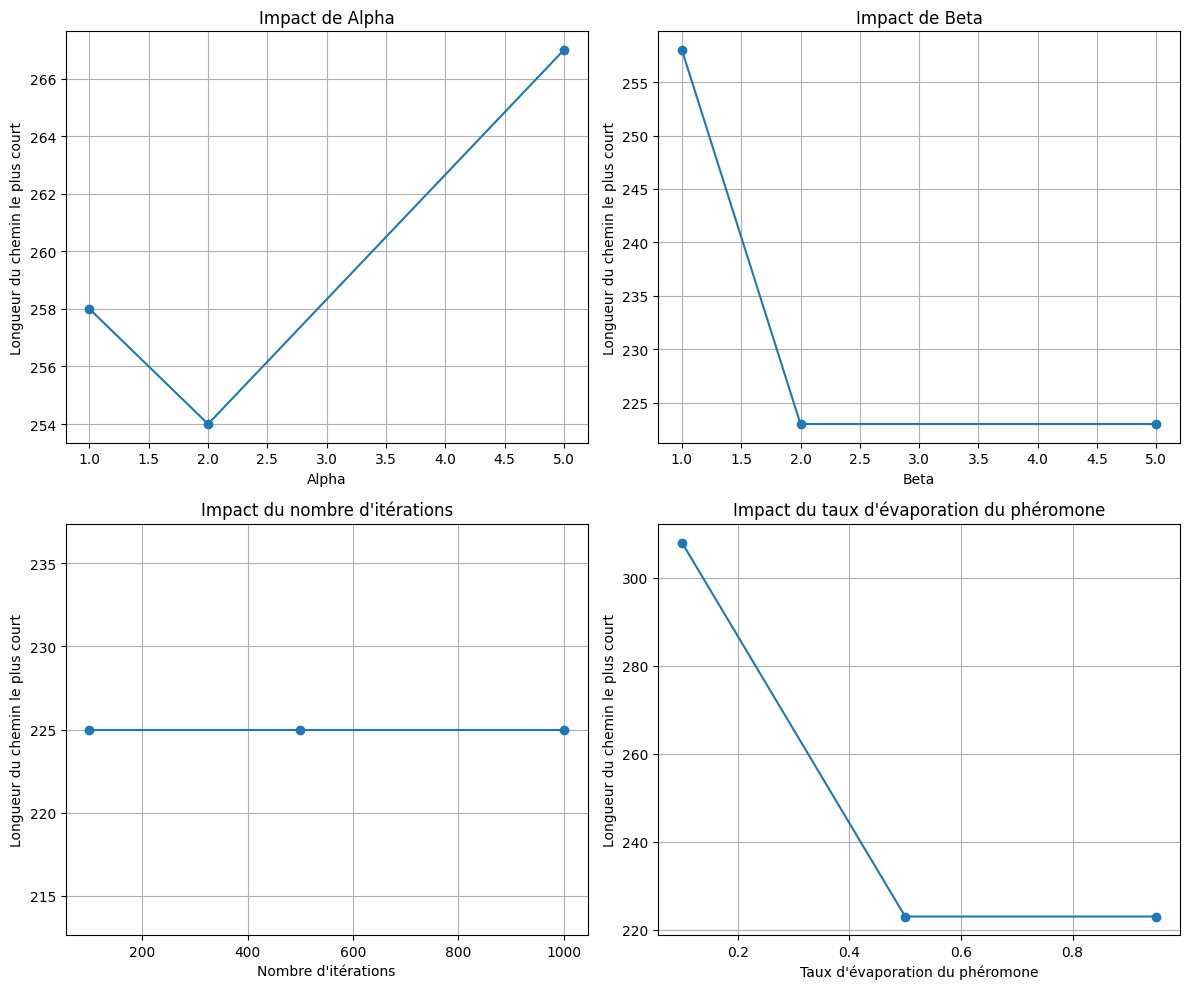

In [45]:
import time
import matplotlib.pyplot as plt

# Fonction pour mesurer le temps d'exécution de l'algorithme avec différents paramètres
def run_with_params(matrice_distances, n_ants, n_best, n_iterations, decay, alpha, beta):
    start_time = time.time()
    aco = AntColonyOptimizer(matrice_distances, n_ants, n_best, n_iterations, decay, alpha, beta)
    path, path_length = aco.run()
    execution_time = time.time() - start_time
    return path_length, execution_time

# Nombre d'itérations : 1000 vs 500 vs 100
n_iterations_values = [100, 500, 1000]
path_lengths_iterations = []
execution_times_iterations = []

for n_iterations in n_iterations_values:
    path_length, execution_time = run_with_params(matrice_distances, 10, 3, n_iterations, 0.95, alpha=1, beta=2)
    path_lengths_iterations.append(path_length)
    execution_times_iterations.append(execution_time)

# Taux d'évaporation du phéromone : 0.95 vs 0.5 vs 0.1
decay_values = [0.95, 0.5, 0.1]
path_lengths_decay = []
execution_times_decay = []

for decay in decay_values:
    path_length, execution_time = run_with_params(matrice_distances, 10, 3, 100, decay, alpha=1, beta=2)
    path_lengths_decay.append(path_length)
    execution_times_decay.append(execution_time)

# Valeurs pour alpha et beta
alpha_values = [1, 2, 5]  
beta_values = [1, 2, 5]   

# Liste pour stocker les résultats
path_lengths_alpha = []
execution_times_alpha = []
path_lengths_beta = []
execution_times_beta = []

# Test avec différentes valeurs de alpha
for alpha in alpha_values:
    path_length, execution_time = run_with_params(matrice_distances, 10, 3, 100, 0.95, alpha, beta=2)
    path_lengths_alpha.append(path_length)
    execution_times_alpha.append(execution_time)

# Test avec différentes valeurs de beta
for beta in beta_values:
    path_length, execution_time = run_with_params(matrice_distances, 10, 3, 100, 0.95, alpha=1, beta=beta)
    path_lengths_beta.append(path_length)
    execution_times_beta.append(execution_time)


# Tracer les graphiques
plt.figure(figsize=(12, 10))

# Graphique pour alpha
plt.subplot(2, 2, 1)
plt.plot(alpha_values, path_lengths_alpha, marker='o')
plt.xlabel('Alpha')
plt.ylabel('Longueur du chemin le plus court')
plt.title('Impact de Alpha')
plt.grid(True)

# Graphique pour beta
plt.subplot(2, 2, 2)
plt.plot(beta_values, path_lengths_beta, marker='o')
plt.xlabel('Beta')
plt.ylabel('Longueur du chemin le plus court')
plt.title('Impact de Beta')
plt.grid(True)

# Graphique pour le nombre d'itérations
plt.subplot(2, 2, 3)
plt.plot(n_iterations_values, path_lengths_iterations, marker='o')
plt.xlabel('Nombre d\'itérations')
plt.ylabel('Longueur du chemin le plus court')
plt.title('Impact du nombre d\'itérations')
plt.grid(True)

# Graphique pour le taux d'évaporation du phéromone
plt.subplot(2, 2, 4)
plt.plot(decay_values, path_lengths_decay, marker='o')
plt.xlabel('Taux d\'évaporation du phéromone')
plt.ylabel('Longueur du chemin le plus court')
plt.title('Impact du taux d\'évaporation du phéromone')
plt.grid(True)

plt.tight_layout()
plt.show()


Pour un dataset de 48 villes :  
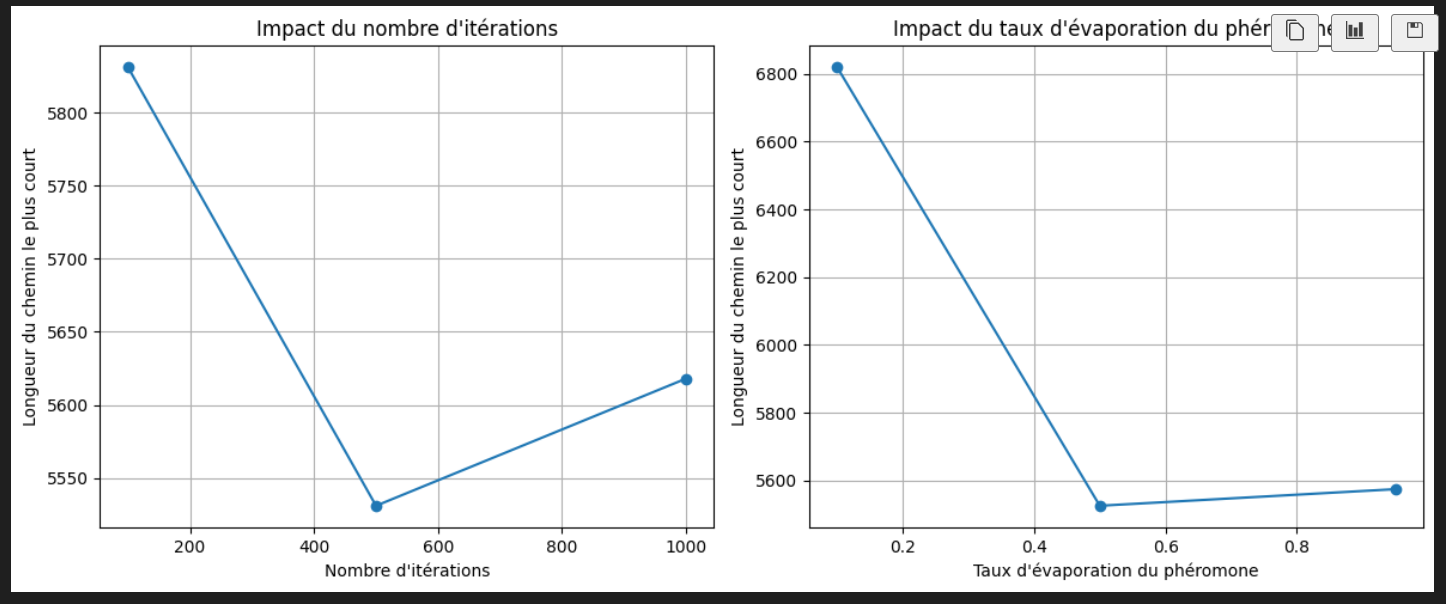

Remarques tirées des graphiques :  
# **Beta (β)**  
On remarque que plus le paramètre beta est supérieur, meilleures sont les performances de l'algorithme. Cela s'explique par le fait qu'en augmentant la valeur de beta, nous accordons plus d'importance à cette heuristique par rapport au phéromone déposé par les fourmis. Cela signifie que les fourmis sont plus susceptibles de privilégier les chemins qui semblent plus courts selon l'heuristique, ce qui peut les guider vers des solutions potentiellement meilleures.  
# **Alpha (α)**
Alpha (α) : Alpha contrôle l'influence du phéromone sur le choix des prochaines villes à visiter par les fourmis, en d'autres termes, les fourmis auront plus tendance à suivre les chemins avec des niveaux de phéromone plus élevés.  
Lorsque alpha est élevé, le poids accordé au phéromone devient plus important par rapport à l'heuristique. Cela signifie que les fourmis ont tendance à suivre davantage les chemins où le phéromone est abondant, sans tenir suffisamment compte de la distance entre les villes. Par conséquent, cela peut entraîner une exploration inefficace de l'espace de recherche, conduisant à des solutions de moindre qualité ou à une convergence plus lente vers des solutions optimales.  

# **Taux d'évaporation du phéromone :**
On remarque que pour le taux d'évaporation du phéromone, plus il est élevé, meilleurs sont les résultats. Cela peut s'expliquer par les points suivants :  
- Lorsque le taux d'évaporation du phéromone est augmenté, les informations obsolètes sont éliminées plus rapidement des routes, ce qui permet aux fourmis de se concentrer sur les chemins les plus prometteurs.  
- Cela évite également la stagnation dans les solutions sous-optimales, car les phéromones sur les chemins moins prometteurs sont rapidement éliminées, permettant aux fourmis de rechercher de nouvelles solutions potentiellement meilleures.  
  

# **Nombre d'itérations :**
**Pour le dataset de 48 villes :**  

Une valeur de 500 itérations semble être la meilleure option. Cela peut être dû au compromis entre l'exploration et l'exploitation : 100 itérations peuvent ne pas permettre une exploration suffisante de l'espace de recherche, tandis que 1000 itérations peuvent entraîner une convergence prématurée vers des solutions sous-optimales.  
La valeur de 500 itérations permet probablement aux fourmis d'explorer une gamme suffisamment large de solutions tout en évitant une convergence prématurée.  

**Pour le dataset de 17 villes :**  

On remarque que le nombre d'itérations n'influe pas vraiment sur le coût. Cela peut être dû à la taille relativement petite du problème, où un nombre plus faible d'itérations suffit pour explorer efficacement l'espace de recherche.  

**Conclusion**
En résumé, l'ajustement des paramètres de l'algorithme ACO est crucial pour obtenir de bonnes performances, et cela dépend souvent de la taille et de la complexité du problème spécifique. Les résultats obtenus soulignent l'importance de trouver un équilibre entre l'exploration et l'exploitation pour obtenir des solutions de qualité.

# --------------------------------------
# Methode 2 : AG : Algorithme Génétique    
L'algorithme génétique pour le problème du voyageur de commerce est une approche métaheuristique visant à trouver une solution optimale en générant une population initiale de permutations aléatoires des villes, évaluant le fitness de chaque individu en fonction de la distance totale du trajet, sélectionnant des individus pour la reproduction en fonction de leur fitness, réalisant la reproduction en croisant deux parents pour créer des enfants et en appliquant une mutation avec une certaine probabilité, et enfin, faisant évoluer la population sur un certain nombre de générations. Les paramètres tels que la taille de la population, le nombre d'individus d'élite conservés, le taux de mutation et le nombre de générations sont ajustables pour influencer les performances de l'algorithme. Une fois toutes les générations complétées, la meilleure solution est identifiée en sélectionnant l'individu avec le score de fitness le plus élevé, représentant le chemin optimal pour le voyageur de commerce, avec la meilleure distance totale parcourue.




In [ ]:
class GeneticAlgorithmTSP:
    def __init__(self, num_cities, pop_size=100, elite_size=20, mutation_rate=0.1, generations=500):
        self.num_cities = num_cities  # Nombre de villes dans le problème
        self.pop_size = pop_size  # Taille de la population
        self.elite_size = elite_size  # Taille de l'élite (meilleurs individus conservés d'une génération à l'autre)
        self.mutation_rate = mutation_rate  # Taux de mutation (probabilité qu'une mutation se produise)
        self.generations = generations  # Nombre de générations à exécuter

    # Cette méthode génère une population initiale de permutations aléatoires des villes.
    def initial_population(self):
        return np.array([np.random.permutation(self.num_cities) for _ in range(self.pop_size)])

    # Cette méthode calcule les scores de fitness pour chaque individu de la population en utilisant la fonction d'évaluation (dans ce cas, l'inverse de la distance totale du trajet).
    def calculate_fitness(self, population, distances):
        fitness_scores = np.zeros(len(population))  # Initialisation d'un tableau de scores de fitness
        for i, individual in enumerate(population):  # Pour chaque individu dans la population
            total_distance = sum([distances[individual[j-1], individual[j]] for j in range(self.num_cities)])  # Calcul de la distance totale du trajet
            fitness_scores[i] = 1 / total_distance  # Score de fitness = 1 / distance totale (plus la distance est courte, meilleur est le score)
        return fitness_scores

    # Cette méthode sélectionne des individus de la population en fonction de leur score de fitness pour la reproduction.
    def selection(self, population, fitness_scores):
        selected_indices = np.random.choice(len(population), size=self.pop_size, p=fitness_scores/fitness_scores.sum())  # Sélection d'individus de la population en fonction de leur score de fitness
        return population[selected_indices]

    #Cette méthode réalise la reproduction en croisant deux parents pour créer un enfant.
    def crossover(self, parent1, parent2):
        child = np.zeros_like(parent1)  # Create a child with the same size as the parents
        start, end = sorted(np.random.choice(self.num_cities, size=2, replace=False))  # Randomly choose start and end positions for crossover
        child[start:end] = parent1[start:end]  # Copy the section from parent1 to the child
        remaining = [city for city in parent2 if city not in child]  # Retrieve missing cities from parent2
        idx = 0
        for i in range(len(child)):
            if child[i] == 0:
                if idx < len(remaining):  # Check if idx is within the range of remaining
                    child[i] = remaining[idx]
                    idx += 1
                else:
                    break  # Break out of the loop if idx exceeds the range of remaining
        return child

    # Cette méthode effectue une mutation sur un individu avec une certaine probabilité de mutation.
    def mutate(self, individual):
        for i in range(self.num_cities):  # Pour chaque ville dans l'individu
            if np.random.rand() < self.mutation_rate:  # Avec une probabilité de mutation
                j = np.random.randint(self.num_cities)  # Choix aléatoire d'une autre ville
                individual[i], individual[j] = individual[j], individual[i]  # Échange de positions entre les deux villes
        return individual

    # Cette méthode évolue la population en sélectionnant l'élite, en réalisant le crossover et en effectuant les mutations
    def evolve_population(self, population, distances):
        elite = population[:self.elite_size]  # Sélection de l'élite de la population
        selection_pool = self.selection(population, self.calculate_fitness(population, distances))  # Sélection d'autres individus pour la reproduction
        children = [self.crossover(selection_pool[i], selection_pool[-i-1]) for i in range(len(selection_pool)//2)]  # Création de nouveaux individus par crossover
        mutated_children = [self.mutate(child) for child in children]  # Mutation des nouveaux individus
        return np.concatenate((elite, mutated_children))  # Retourne la nouvelle population

    # Cette méthode exécute l'algorithme génétique sur un ensemble de distances données, en générant une population initiale et en faisant évoluer cette population sur un certain nombre de générations.
    def genetic_algorithm(self, distances):
        population = self.initial_population()  # Génère une population initiale
        for _ in range(self.generations):  # Pour chaque génération
            population = self.evolve_population(population, distances)  # Évolution de la population
        best_route_idx = np.argmax(self.calculate_fitness(population, distances))  # Indice de la meilleure solution dans la population finale
        best_route = population[best_route_idx]  # Meilleure solution
        best_distance = 1 / self.calculate_fitness(population, distances)[best_route_idx]  # Calcul de la meilleure distance
        return best_route, best_distance  # Retourne la meilleure route et la meilleure distance


# Configuration de l'algorithme génétique
ga = GeneticAlgorithmTSP(num_cities=nombre_villes, pop_size=100, elite_size=20, mutation_rate=0.01, generations=500)

# Exécution de l'algorithme génétique
best_route, best_distance = ga.genetic_algorithm(matrice_distances)  # Meilleure route et meilleure distance
print("Meilleure route trouvée:", best_route)  # Affichage de la meilleure route
print("Meilleure distance:", best_distance)  # Affichage de la meilleure distance


Meilleure route trouvée: [ 3  6  7  9 12 13  8 14 11 15 16  2  5 10  4  1  0]
Meilleure distance: 409.0


# **Analyse de l'impact des paramètres sur les performances de l'AG**

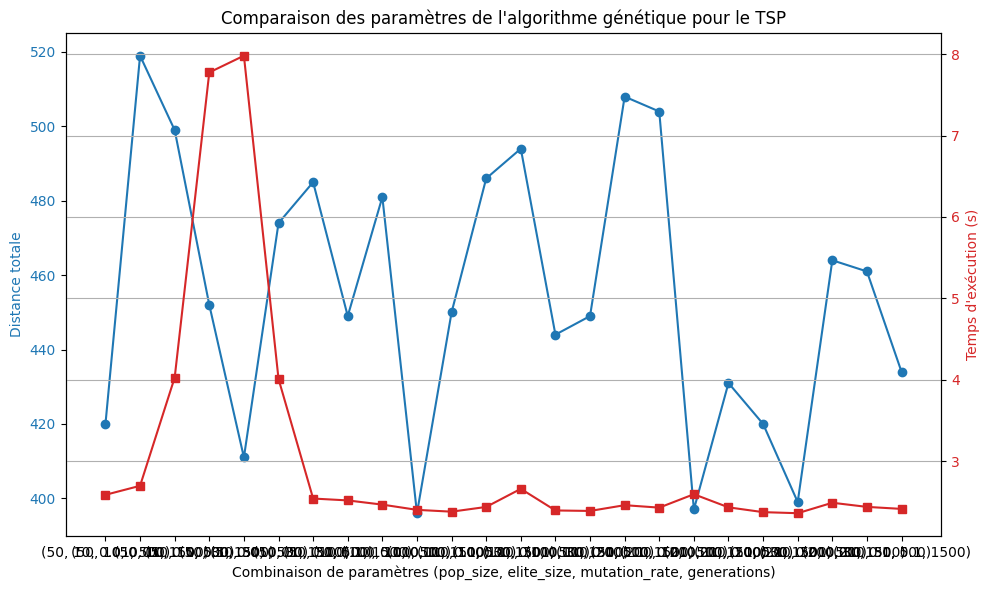

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time
import xml.etree.ElementTree as ET

class GeneticAlgorithmTSP:
    def __init__(self, num_cities, pop_size=100, elite_size=20, mutation_rate=0.1, generations=500):
        self.num_cities = num_cities  # Nombre de villes dans le problème
        self.pop_size = pop_size  # Taille de la population
        self.elite_size = elite_size  # Taille de l'élite (meilleurs individus conservés d'une génération à l'autre)
        self.mutation_rate = mutation_rate  # Taux de mutation (probabilité qu'une mutation se produise)
        self.generations = generations  # Nombre de générations à exécuter

    # Les méthodes de l'algorithme génétique...

def run_genetic_algorithm(num_cities, pop_size, elite_size, mutation_rate, generations):
    debut = time.time()  # Enregistrer le temps de début
    best_route, best_distance = ga.genetic_algorithm(matrice_distances)  # Exécuter l'algorithme génétique
    fin = time.time()  # Enregistrer le temps de fin
    temps_execution = fin - debut  # Calculer le temps d'exécution
    return best_route, best_distance, temps_execution

# Charger le fichier XML
tree = ET.parse('data.xml')  # Chargement du fichier XML
root = tree.getroot()  # Récupération de la racine du fichier XML

# Initialiser la matrice des distances
nombre_villes = len(root.find('graph').findall('vertex'))  # Nombre de villes
matrice_distances = np.zeros((nombre_villes, nombre_villes))  # Initialisation de la matrice des distances

# Remplir la matrice des distances
for i, vertex in enumerate(root.find('graph').findall('vertex')):  # Pour chaque ville
    for edge in vertex.findall('edge'):  # Pour chaque bord
        j = int(edge.text)  # L'indice de la ville de destination
        cost = float(edge.get('cost'))  # Le coût pour se rendre à cette ville
        matrice_distances[i, j] = cost  # Assigner le coût à la matrice des distances

# Définir les valeurs des paramètres à tester pour l'algorithme génétique
pop_sizes = [50, 100, 200]
elite_sizes = [10, 30]
mutation_rates = [0.01, 0.1]
generations = [500, 1500]

# Stocker les résultats
resultats_genetique = {}

# Exécuter l'algorithme pour chaque combinaison de paramètres
for pop_size in pop_sizes:
    for elite_size in elite_sizes:
        for mutation_rate in mutation_rates:
            for generation in generations:
                best_route, best_distance, temps_execution = run_genetic_algorithm(nombre_villes, pop_size, elite_size, mutation_rate, generation)
                resultats_genetique[(pop_size, elite_size, mutation_rate, generation)] = (best_distance, temps_execution)

# Créer le graphique
x_genetique = [str(combinaison) for combinaison in resultats_genetique.keys()]
y_distance_genetique = [resultats_genetique[combinaison][0] for combinaison in resultats_genetique.keys()]
y_temps_genetique = [resultats_genetique[combinaison][1] for combinaison in resultats_genetique.keys()]

fig, ax1 = plt.subplots(figsize=(10, 6))

# Tracer la distance totale de la meilleure solution
color = 'tab:blue'
ax1.set_xlabel('Combinaison de paramètres (pop_size, elite_size, mutation_rate, generations)')
ax1.set_ylabel('Distance totale', color=color)
ax1.plot(x_genetique, y_distance_genetique, marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Créer un axe y supplémentaire pour le temps d'exécution
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Temps d\'exécution (s)', color=color)
ax2.plot(x_genetique, y_temps_genetique, marker='s', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Comparaison des paramètres de l\'algorithme génétique pour le TSP')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()


**Taille de la population**
*  Augmenter la taille de la population peut potentiellement permettre à l'algorithme de mieux explorer l'espace de recherche en augmentant la diversité des solutions.
*   Cependant, une population trop grande peut également augmenter le temps de calcul et la consommation de ressources.

**Taille de l'élite (elite_size)**

*   Une taille d'élite plus grande permet de conserver un plus grand nombre de bonnes solutions d'une génération à l'autre, ce qui peut accélérer la convergence vers une solution optimale.
*   Cependant, une taille d'élite trop grande peut entraîner une perte de diversité génétique au sein de la population, ce qui peut réduire l'efficacité de l'algorithme.

**Taux de mutation (mutation_rate)**


*   Un taux de mutation plus élevé peut aider à sortir des optimums locaux en introduisant de nouvelles solutions dans la population.
*   Cependant, un taux de mutation trop élevé peut perturber la convergence vers une solution optimale en introduisant trop de bruit dans le processus évolutif.
*  Un taux de mutation trop faible peut entraîner une stagnation de la recherche en limitant l'exploration de l'espace des solutions.

**Nombre de générations (generations)**


*  Un nombre plus élevé de générations permet généralement à l'algorithme d'explorer plus en profondeur l'espace des solutions et d'améliorer la qualité de la solution finale.
*   Cependant, un nombre de générations trop élevé peut entraîner un temps de calcul excessif, surtout si la convergence est atteinte plus tôt.
*   Un nombre de générations trop faible peut entraîner une convergence prématurée vers une solution sous-optimale.



En analysant ces paramètres, On peut observer comment leurs variations influencent les performances de l'algorithme génétique pour le PVC. Par exemple, On peut constater qu'une augmentation de la taille de la population améliore la qualité de la solution, mais entraîne également une augmentation du temps de calcul. De même, On peut constater qu'un taux de mutation plus élevé aide à sortir des optimums locaux, mais trop de mutations peuvent nuire à la convergence de l'algorithme. En ajustant judicieusement ces paramètres, on peut trouver un équilibre entre l'exploration de l'espace des solutions et l'exploitation des solutions déjà trouvées, ce qui peut conduire à de meilleures performances de l'algorithme génétique pour le PVC.




# **Conclusion**:  
Dans le cadre de ce TP, en comparant entre les algorithmes génétiques (AG) et l'optimisation par colonies de fourmis (ACO) pour résoudre le problème du voyageur de commerce, nous avons observé que l'ACO a généralement produit des résultats plus prometteurs que les AG.

L'ACO a démontré une capacité supérieure à trouver des solutions de qualité, représentées par des chemins plus courts, tout en maintenant une stabilité dans les résultats sur différents ensembles de paramètres. Cette constatation suggère que l'ACO est plus robuste et fiable dans la résolution du problème du voyageur de commerce, offrant des performances globalement meilleures par rapport aux AG.